# DES Y1 Mass-Richness Calibration

Compare Capish theoretical predictions against DES Y1 cluster observations.

- Survey area: 1603.5 deg²
- Richness bins: [20-30, 30-45, 45-60, 60-200] (includes highest richness bin)
- Redshift bins: [0.2-0.35, 0.35-0.5, 0.5-0.65]

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import pandas as pd
import sys
import os
import configparser

# Add modules to path
root_path = os.path.abspath('../../')
sys.path.insert(0, root_path)
from modules.simulation import UniverseSimulator

plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

print("Imports loaded successfully")

Imports loaded successfully


## Load DES Y1 Data

In [2]:
# Load DES Y1 RedMaPPer catalogue
file_path = '/sps/euclid/Users/cmurray/clusters_likelihood/redmapper_y1a1_public_v6.4_catalog.fits.gz'
redmapper_catalogue = Table.read(file_path, format='fits')
redmapper_catalogue.remove_columns(['P_CEN', 'RA_CEN', 'DEC_CEN', 'ID_CEN', 'PZBINS', 'PZ'])
redmapper_catalogue = redmapper_catalogue.to_pandas()

# Define binning (now including the highest richness bin)
lambda_bins = np.array([20, 30, 45, 60, 200])
z_bins = np.array([0.2, 0.35, 0.5, 0.65])
lambda_cents = np.array([25.0, 37.5, 52.5, 130.0])

n_lambda_bins = len(lambda_bins) - 1
n_z_bins = len(z_bins) - 1

print(f"Loaded {len(redmapper_catalogue)} clusters")
print(f"Richness bins: {lambda_bins}")
print(f"Redshift bins: {z_bins}")
print(f"Total calibration bins: {n_lambda_bins * n_z_bins}")

Loaded 6729 clusters
Richness bins: [ 20  30  45  60 200]
Redshift bins: [0.2  0.35 0.5  0.65]
Total calibration bins: 12


In [3]:
# Extract DES observed counts
des_counts = np.zeros((n_z_bins, n_lambda_bins))
for i in range(n_z_bins):
    z_mask = (redmapper_catalogue['Z_LAMBDA'] >= z_bins[i]) & (redmapper_catalogue['Z_LAMBDA'] < z_bins[i+1])
    counts, _ = np.histogram(redmapper_catalogue['LAMBDA'][z_mask], bins=lambda_bins)
    des_counts[i] = counts

# DES mean masses (with h correction) - extended to include highest richness bin
des_masses = np.array([
    [14.036, 14.323, 14.454, 14.650],  # z: 0.2-0.35, added estimate for λ>60
    [14.007, 14.291, 14.488, 14.680],  # z: 0.35-0.5, added estimate for λ>60
    [13.929, 14.301, 14.493, 14.700]   # z: 0.5-0.65, added estimate for λ>60
]) + np.log10(0.744)  # h correction

# Mass uncertainties - extended to include highest richness bin
des_mass_errors = np.array([
    [0.077, 0.082, 0.094, 0.150],  # Combined stat + sys, larger error for λ>60
    [0.089, 0.092, 0.109, 0.160],  # due to smaller sample size
    [0.120, 0.127, 0.124, 0.180]
])

print(f"DES observed counts:")
print(des_counts)
print(f"\nTotal observed clusters: {des_counts.sum()}")

DES observed counts:
[[ 762.  376.  123.   91.]
 [1549.  672.  187.  147.]
 [1612.  687.  205.   92.]]

Total observed clusters: 6503.0


## Run Capish Simulation

In [12]:
def create_capish_config(mr_params, cosmo_params, area_sr):
    """Create Capish configuration."""
    config = configparser.ConfigParser()
    
    # Unified parameters
    config['parameters'] = {**cosmo_params, **mr_params}
    
    # Halo catalogue
    config['halo_catalogue'] = {
        'hmf_name': 'Tinker10',
        'bias_model': 'Tinker10',
        'sky_area': str(area_sr),
        'log10m_min': '13.0',
        'log10m_max': '16.0',
        'n_mass_bins': '1000',
        'z_min': '0.1',
        'z_max': '0.8',
        'n_redshift_bins': '700',
        'SSC': 'False',
        'mass_def_overdensity_type': 'critical',
        'mass_def_overdensity_delta': '200',
        'Mstar': '10',
        's': '0.0',
        'q': '1.0',
        'SSC': 'False',
        #'recompute_SSC_fiducial': 'False',
        # 'name_sigma2ij_fullsky_file': 'sigma2ij_fullsky_fiducial_zmin={}_zmax={}_nzbins={}.pkl',
        #'save_new_SSC_fiducial': 'False'
        'Omega_c_fiducial': '0.25',
        'Omega_b_fiducial': '0.049',
        'h_fiducial': '0.674',
        'sigma_8_fiducial': '0.811',
        'n_s_fiducial': '0.965'
    }
    
    # Cluster catalogue
    config['cluster_catalogue'] = {
        'add_completeness': 'False',
        'params_completeness': '1.0, 0.0, 14.0, 0.0',
        'add_photometric_redshift': 'False',
        'add_purity': 'False',
        'params_purity': '1.0, 0.0, 2.0, 0.0',
        'add_selection': 'False'
    }
    
    config['cluster_catalogue.mass_observable_relation'] = {
        'which_relation': 'Gauss+Poiss-corr'
    }
    
    config['cluster_catalogue.photometric_redshift'] = {
        'sigma_z0': '0.02'
    }
    
    # Summary statistics - updated for 4 richness bins (comma-separated without spaces)
    config['summary_statistics'] = {
        'summary_statistic': 'binned_count_mean_mass',
        'Gamma': 2/3,
        'richness_edges': ','.join(map(str, lambda_bins)),
        'redshift_edges': ','.join(map(str, z_bins)),
    }
    
    return config


Capish: $\mu_{\lambda} = \alpha_{\lambda} + \beta_{\lambda} \rm{log}_{10} (M -M_{\rm{Min}}) + \gamma_{\lambda} \rm{log}_{10} (1+z)$

DES y1: $\mu_{\lambda} = \alpha \rm{log}_{10} \left( \frac{M-M_{\rm{min}}}{M_1-M_{\rm{min}}}\right) + \epsilon \rm{log}_{10} \left( \frac{1+z}{1+z_0}\right)$

Therefore,

$\alpha_{\lambda} = -\alpha \rm{log}_{10} (M_1 - M_{\rm{min}}) - \epsilon \rm{log}_{10} ( 1+ z_0)$ 

$\beta_{\lambda} = \alpha$

$\gamma_{\lambda} = \epsilon$


In [13]:
-0.748 * np.log10( 10**12.37 - 10**11.13 ) + 0.07 * np.log10( 1 + 0.5 )

np.float64(-9.221180904595387)

In [14]:
# Mass-richness relation parameters (updated for new relation format)
MASS_RICHNESS_PARAMS = {
    'M_min': 134896288259.1656,  # 10^11.13 in solar masses
    'alpha_lambda': -9,
    'beta_lambda': 0.75,
    'gamma_lambda': 0.0,
    'sigma_lambda': 0.0,
    'alpha_mwl': 0.0,
    'beta_mwl': 1.0,
    'gamma_mwl': 0.0,
    'sigma_Mwl_gal': 0.2,
    'sigma_Mwl_int': 0.2,
    'rho': 0.2
}

# Cosmological parameters
COSMO_PARAMS = {
    'Omega_m': 0.18,
    'sigma8': 0.85,
    'Omega_b': 0.049,
    'h': 0.674,
    'ns': 0.965,
    'w0': -1,
    'wa': 0
}

# DES survey area
DES_AREA_DEG2 = 1600.4
DES_AREA_SR = DES_AREA_DEG2 * (np.pi/180)**2

print(f"DES survey area: {DES_AREA_DEG2} deg² ({DES_AREA_SR:.6f} sr)")

DES survey area: 1600.4 deg² (0.487510 sr)


In [15]:
( 40000 * ( np.pi/180)**2 ) / ( 4 * np.pi)

0.9696273622190719

In [16]:
config = create_capish_config(MASS_RICHNESS_PARAMS, COSMO_PARAMS, DES_AREA_SR)
print("Capish configuration created")

Capish configuration created


In [17]:
list(config.keys())

['DEFAULT',
 'parameters',
 'halo_catalogue',
 'cluster_catalogue',
 'cluster_catalogue.mass_observable_relation',
 'cluster_catalogue.photometric_redshift',
 'summary_statistics']

In [18]:
config['parameters']

<Section: parameters>

In [19]:
# Run simulation
simulator = UniverseSimulator(default_config=config, variable_params_names=['Omega_m', 'sigma8', 'alpha_lambda', 'beta_lambda', 'gamma_lambda', 'M_min'])
fiducial_values = [COSMO_PARAMS['Omega_m'], COSMO_PARAMS['sigma8'], 
                   MASS_RICHNESS_PARAMS['alpha_lambda'], MASS_RICHNESS_PARAMS['beta_lambda'], 
                   MASS_RICHNESS_PARAMS['gamma_lambda'], MASS_RICHNESS_PARAMS['M_min']]

print(f"Running simulation with:")
print(f"  Ωm={fiducial_values[0]}, σ8={fiducial_values[1]}")
print(f"  alpha={fiducial_values[2]}, beta={fiducial_values[3]}")
print(f"  gamma={fiducial_values[4]}, Mmin={fiducial_values[5]:.2e}")
print(f"Expected output shape: {n_z_bins} x {n_lambda_bins} = {n_z_bins}x{n_lambda_bins}")
summary_stats = simulator.run_simulation(fiducial_values)

Running simulation with:
  Ωm=0.18, σ8=0.85
  alpha=-9, beta=0.75
  gamma=0.0, Mmin=1.35e+11
Expected output shape: 3 x 4 = 3x4


In [20]:
def summary_statistic_to_sensible_format(summary_statistic, n_z=3, n_lambda=4):
    """Format Capish results - now returns tuple (count_stat, mass_stat)."""
    
    if isinstance(summary_statistic, tuple) and len(summary_statistic) == 2:
        # New format: tuple of (counts, masses) 
        count_stat, mass_stat = summary_statistic
        sim_n_clusters = np.array(count_stat)
        sim_mwl_mean = np.array(mass_stat)
        
        # Check if we need to transpose - Capish returns (n_lambda, n_z) but we want (n_z, n_lambda)
        if sim_n_clusters.shape == (n_lambda, n_z):
            sim_n_clusters = sim_n_clusters.T
            sim_mwl_mean = sim_mwl_mean.T
            
    else:
        # Old format: flat array
        n_total_bins = n_z * n_lambda
        sim_n_clusters = summary_statistic[:n_total_bins].reshape(n_z, n_lambda)
        sim_mwl_mean = summary_statistic[n_total_bins:].reshape(n_z, n_lambda)
    
    return sim_n_clusters, sim_mwl_mean

# Format the Capish results
capish_counts, capish_masses = summary_statistic_to_sensible_format(summary_stats, n_z_bins, n_lambda_bins)

print(f"Summary stats type: {type(summary_stats)}")
if isinstance(summary_stats, tuple):
    print(f"Tuple length: {len(summary_stats)}")
    for i, item in enumerate(summary_stats):
        print(f"  Item {i}: type={type(item)}, shape={getattr(item, 'shape', 'N/A')}")

print(f"Raw Capish results shape: {summary_stats[0].shape}")
print(f"Capish counts shape after formatting: {capish_counts.shape}")
print(f"Capish masses shape after formatting: {capish_masses.shape}")
print(f"Capish counts:\n{capish_counts}")
print(f"Capish masses:\n{capish_masses}")

Summary stats type: <class 'tuple'>
Tuple length: 2
  Item 0: type=<class 'numpy.ndarray'>, shape=(4, 3)
  Item 1: type=<class 'numpy.ndarray'>, shape=(4, 3)
Raw Capish results shape: (4, 3)
Capish counts shape after formatting: (3, 4)
Capish masses shape after formatting: (3, 4)
Capish counts:
[[1983.  917.  318.  253.]
 [4203. 1896.  631.  493.]
 [6200. 2681.  847.  644.]]
Capish masses:
[[13.85615234 14.10553359 14.35646655 14.63204073]
 [13.85919971 14.12594758 14.32786147 14.61421273]
 [13.86627939 14.10761332 14.33083008 14.62006248]]


## Tutorial-Style Comparison Plot

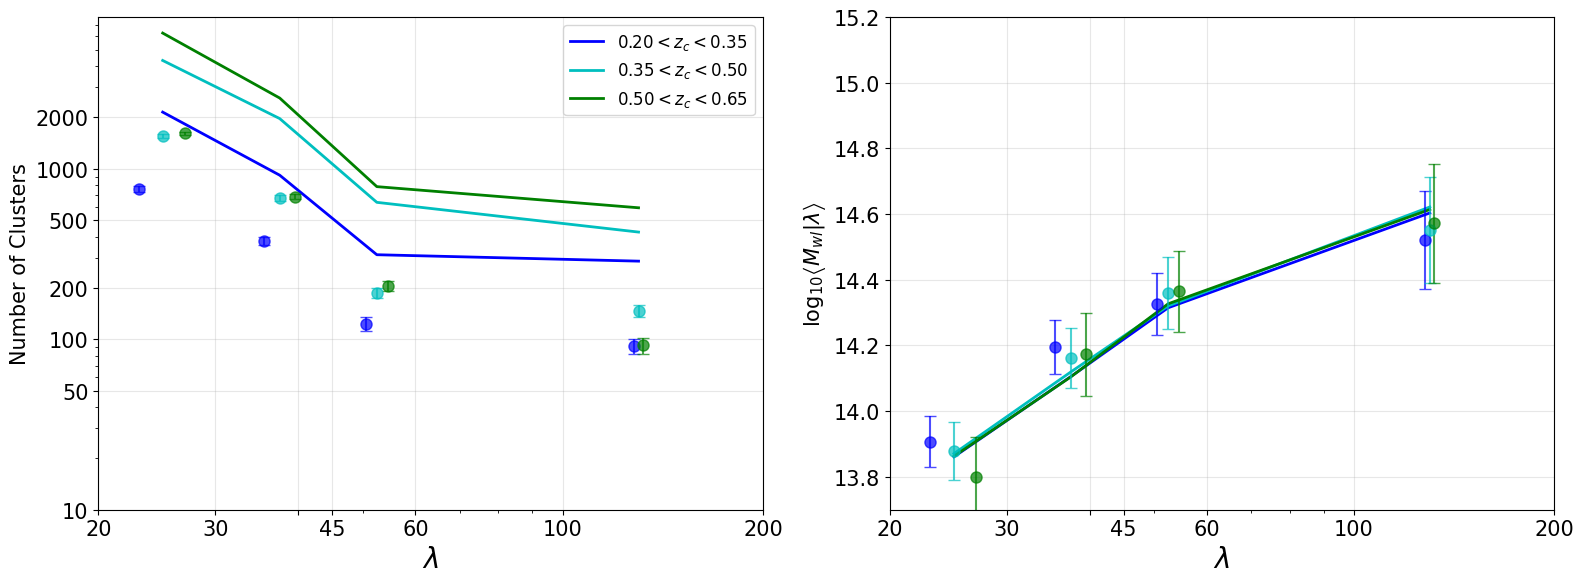


CAPISH vs DES Y1 COMPARISON

z-bin 1 (0.20-0.35):
  DES counts:     [762. 376. 123.  91.]
  Capish counts:  [2148  916  313  287]
  DES masses:     [13.908, 14.195, 14.326, 14.522]
  Capish masses:  [13.861, 14.106, 14.315, 14.603]

z-bin 2 (0.35-0.50):
  DES counts:     [1549.  672.  187.  147.]
  Capish counts:  [4314 1968  635  425]
  DES masses:     [13.879, 14.163, 14.36 , 14.552]
  Capish masses:  [13.871, 14.12 , 14.32 , 14.622]

z-bin 3 (0.50-0.65):
  DES counts:     [1612.  687.  205.   92.]
  Capish counts:  [6245 2597  785  590]
  DES masses:     [13.801, 14.173, 14.365, 14.572]
  Capish masses:  [13.863, 14.105, 14.327, 14.614]


In [ ]:
# Set the figure size
plt.figure(figsize=(16, 6))

# Colors and labels for redshift bins
colors = ['b-', 'c-', 'g-']
z_labels = ['$ 0.20 < z_c < 0.35 $', '$ 0.35 < z_c < 0.50 $', '$ 0.50 < z_c < 0.65 $']

# Subplot 1: Number of clusters
plt.subplot(121)

# Plot Capish predictions
for i in range(n_z_bins):
    plt.plot(lambda_cents, capish_counts[i, :], colors[i], linewidth=2, label=z_labels[i])

# Plot DES observations as points
for i in range(n_z_bins):
    count_errors = np.sqrt(np.maximum(des_counts[i, :], 1))
    plt.errorbar(lambda_cents + (i-1)*2, des_counts[i, :], yerr=count_errors,
                fmt='o', color=colors[i][0], markersize=8, capsize=4, alpha=0.7)

plt.xscale('log')
plt.yscale('log')
plt.yticks([10, 50, 100, 200, 500, 1000, 2000], labels=[10, 50, 100, 200, 500, 1000, 2000])
plt.xlabel(r'$\lambda$', fontsize=20)
plt.ylabel('Number of Clusters', fontsize=15)
plt.legend(loc='upper right', fontsize=12)
plt.xticks(ticks=[20, 30, 40, 45, 60, 100, 200],
           labels=[20, 30, None, 45, 60, 100, 200], fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True, alpha=0.3)

# Subplot 2: Mean MWL
plt.subplot(122)

# Plot Capish predictions
for i in range(n_z_bins):
    plt.plot(lambda_cents, capish_masses[i, :], colors[i], linewidth=2, label=z_labels[i])

# Plot DES observations as points
for i in range(n_z_bins):
    plt.errorbar(lambda_cents + (i-1)*2, des_masses[i, :], yerr=des_mass_errors[i, :],
                fmt='o', color=colors[i][0], markersize=8, capsize=4, alpha=0.7)

plt.xscale('log')
plt.ylim(13.7, 15.2)
plt.xlabel(r'$\lambda$', fontsize=20)
plt.ylabel(r'log$_{10} \left< M_{wl} | \lambda \right>$', fontsize=15)
plt.xticks(ticks=[20, 30, 40, 45, 60, 100, 200],
           labels=[20, 30, None, 45, 60, 100, 200], fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*60)
print("CAPISH vs DES Y1 COMPARISON")
print("="*60)
for i in range(n_z_bins):
    print(f"\nz-bin {i+1} ({z_bins[i]:.2f}-{z_bins[i+1]:.2f}):")
    print(f"  DES counts:     {des_counts[i, :]}")
    print(f"  Capish counts:  {capish_counts[i, :].astype(int)}")
    print(f"  DES masses:     {np.array2string(des_masses[i, :], precision=3, separator=', ')}")
    print(f"  Capish masses:  {np.array2string(capish_masses[i, :], precision=3, separator=', ')}")

## Parameter Iteration

Modify `MASS_RICHNESS_PARAMS` above and re-run cells to calibrate parameters.

## Catalog Diagnostics

In [ ]:
-np.log10( 10**12.37 - 10**11.13) *0.75 # alpha * log10( M1 - Mmin )

np.float64(-9.25819581490236)

In [ ]:
MASS_RICHNESS_PARAMS = {
    'M_min': 134896288259.1656,  # 10^11.13 in solar masses
    'alpha_lambda': -9,
    'beta_lambda': 0.75,
    'gamma_lambda': 0.0,
    'sigma_lambda': 0.25,
    'alpha_mwl': 0.0,
    'beta_mwl': 1.0,
    'gamma_mwl': 0.0,
    'sigma_Mwl_gal': 0.2,
    'sigma_Mwl_int': 0.2,
    'rho': 0.2
}

In [ ]:
fiducial_values = [COSMO_PARAMS['Omega_m'], COSMO_PARAMS['sigma8'], 
                   MASS_RICHNESS_PARAMS['alpha_lambda'], MASS_RICHNESS_PARAMS['beta_lambda'], 
                   MASS_RICHNESS_PARAMS['gamma_lambda'], MASS_RICHNESS_PARAMS['M_min']]


In [ ]:
fiducial_values

[0.1, 0.85, -9, 0.75, 0.0, 134896288259.1656]

In [ ]:
# Generate halo and cluster catalogs using existing methods
log10m_true, z_true = simulator.run_simulation_halo_catalogue(fiducial_values)
richness, log10mWL, z_obs = simulator.run_simulation_cluster_catalogue(fiducial_values)

print(f"Generated {len(log10m_true)} halos")
print(f"Generated {len(richness)} clusters")
print(f"Halo mass range: {np.min(log10m_true):.2f} - {np.max(log10m_true):.2f}")
print(f"Cluster richness range: {np.min(richness):.1f} - {np.max(richness):.1f}")
print(f"Cluster redshift range: {np.min(z_obs):.3f} - {np.max(z_obs):.3f}")

Generated 118615 halos
Generated 119026 clusters
Halo mass range: 13.00 - 15.33
Cluster richness range: 0.8 - 313.9
Cluster redshift range: 0.101 - 0.799


In [ ]:
len( richness )

119026

In [ ]:
len( log10m_true )

118615

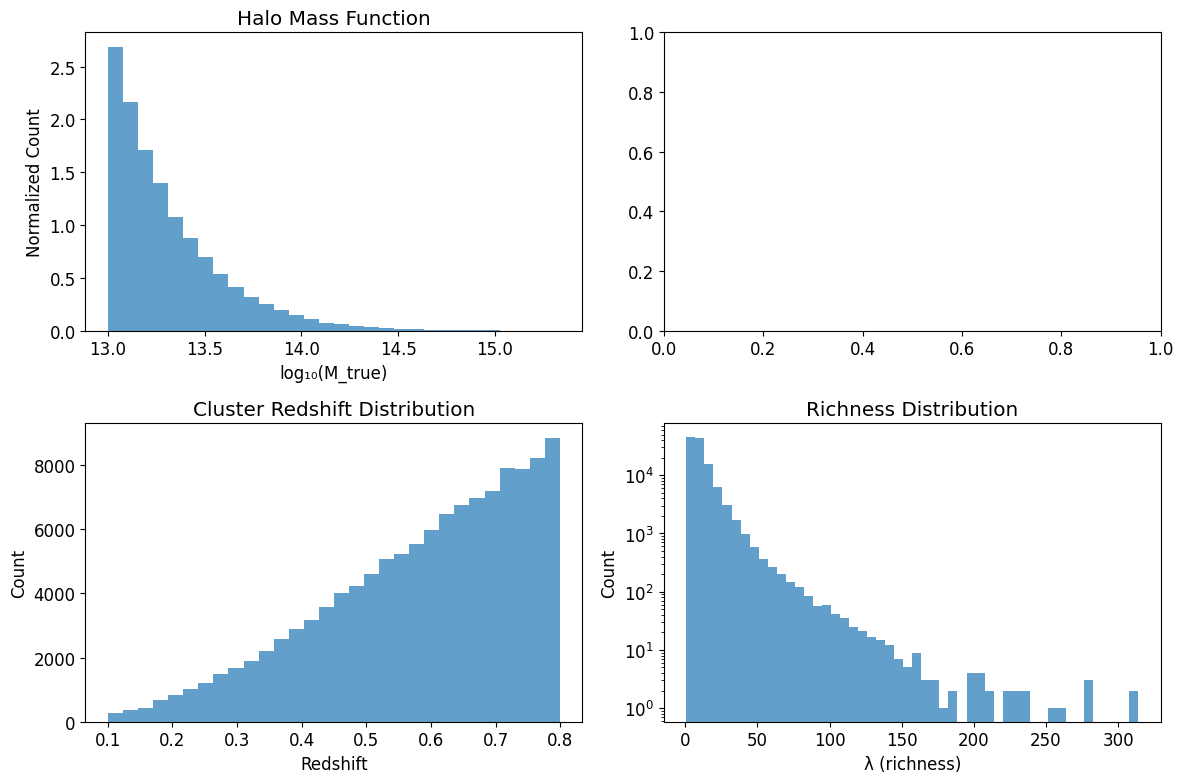

In [ ]:
# Plot catalog diagnostics
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Halo mass function
axes[0,0].hist(log10m_true, bins=30, alpha=0.7, density=True)
axes[0,0].set_xlabel('log₁₀(M_true)')
axes[0,0].set_ylabel('Normalized Count')
axes[0,0].set_title('Halo Mass Function')

# Mass-richness relation
# axes[0,1].scatter(log10m_true, richness, alpha=0.5, s=1)
# axes[0,1].set_xlabel('log₁₀(M_true)')
# axes[0,1].set_ylabel('λ (richness)')
# axes[0,1].set_yscale('log')
# axes[0,1].set_title('Mass-Richness Relation')

# Redshift distribution
axes[1,0].hist(z_obs, bins=30, alpha=0.7)
axes[1,0].set_xlabel('Redshift')
axes[1,0].set_ylabel('Count')
axes[1,0].set_title('Cluster Redshift Distribution')

# Richness distribution
axes[1,1].hist(richness, bins=50, alpha=0.7)
axes[1,1].set_xlabel('λ (richness)')
axes[1,1].set_ylabel('Count')
axes[1,1].set_yscale('log')
axes[1,1].set_title('Richness Distribution')

plt.tight_layout()
plt.show()

In [ ]:
# Example parameter modifications for new relation format:
# MASS_RICHNESS_PARAMS['alpha_lambda'] = 12.0    # Adjust normalization
# MASS_RICHNESS_PARAMS['beta_lambda'] = 0.8      # Adjust mass scaling
# MASS_RICHNESS_PARAMS['gamma_lambda'] = 0.1     # Add redshift evolution

print("Current parameters (new relation format):")
for key, value in MASS_RICHNESS_PARAMS.items():
    print(f"  {key}: {value}")
    
print("\nNew relation: mu_lambda = alpha_lambda + beta_lambda * log10((M - M_min)) + gamma_lambda * log10(1 + z)")
print("Lensing relation: mu_mWL = alpha_mwl + beta_mwl * log10(M) + gamma_mwl * log10(1 + z)")

Current parameters (new relation format):
  M_min: 134896288259.1656
  alpha_lambda: 12.47
  beta_lambda: 0.75
  gamma_lambda: 0.0
  sigma_lambda: 0.25
  alpha_mwl: 0.0
  beta_mwl: 1.0
  gamma_mwl: 0.0
  sigma_Mwl_gal: 0.2
  sigma_Mwl_int: 0.2
  rho: 0.2

New relation: mu_lambda = alpha_lambda + beta_lambda * log10((M - M_min)) + gamma_lambda * log10(1 + z)
Lensing relation: mu_mWL = alpha_mwl + beta_mwl * log10(M) + gamma_mwl * log10(1 + z)
